In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tqdm.autonotebook as tqdm

/tmp/ipykernel_761051/630626742.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [2]:
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift, estimate_bandwidth

In [3]:
from conformal_region_designer.density_estimation import KDE, NoOpDensityEstimator
from conformal_region_designer.clustering import MeanShiftClustering
from conformal_region_designer.shapes import ConvexHullTemplate, HyperRectangle
from conformal_region_designer.conformity_optimizer import ConformalRegion
DELTA = 0.95

In [4]:
train_samples = 10_000
cal_samples = 10_000
test_samples = 10_000
n_samples = train_samples + cal_samples + test_samples
dataset = make_blobs(n_samples=n_samples, centers=4, cluster_std=[1.0,2.5,0.5,3.0], random_state=42)
total_samples = dataset[0].shape[0]
Z_train = dataset[0][: train_samples]
Z_cal_two = dataset[0][train_samples : train_samples + cal_samples]
Z_test = dataset[0][train_samples + cal_samples :]

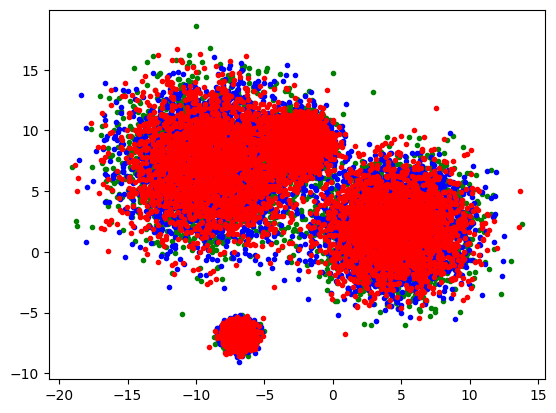

In [5]:
fig, ax = plt.subplots()
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="cal")
ax.scatter(Z_train[:, 0], Z_train[:, 1], color="red", marker=".", label="train")

In [6]:
SEED = 42
np.random.seed(SEED)

In [24]:
DRAWS = 100
samples = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1_000]
samples = [200]
data = []

with tqdm.tqdm(total=len(samples) * DRAWS) as pbar:
    for sample in samples:
        for i in range(DRAWS):
            Z_cal_one = Z_train[np.random.choice(Z_train.shape[0], sample, replace=False)]
                        
            pcr = ConformalRegion(KDE(), MeanShiftClustering(), ConvexHullTemplate, DELTA)
            pcr.fit(Z_cal_one)
            pcr.conformalize(Z_cal_two)
            vol = pcr.volume()
            scores = pcr.calculate_scores(Z_test) 
            coverage = np.sum(scores < 0) / len(scores)
            data.append({
                'samples': sample,
                'coverage': coverage,
                'volume': vol,
                'kde': True,
                'normalizing_constant': pcr.normalizing_constant
            })

            pcr = ConformalRegion(NoOpDensityEstimator(), MeanShiftClustering(), ConvexHullTemplate, DELTA)
            pcr.fit(Z_cal_one)
            pcr.conformalize(Z_cal_two)
            vol = pcr.volume()
            scores = pcr.calculate_scores(Z_test) 
            coverage = np.sum(scores < 0) / len(scores)
            data.append({
                'samples': sample,
                'coverage': coverage,
                'volume': vol,
                'kde': False,
                'normalizing_constant': pcr.normalizing_constant
            })

            pbar.update(1)
        

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
import pandas as pd
data = pd.DataFrame(data)
kde_data = data[data['kde'] == True]
no_kde_data = data[data['kde'] == False]

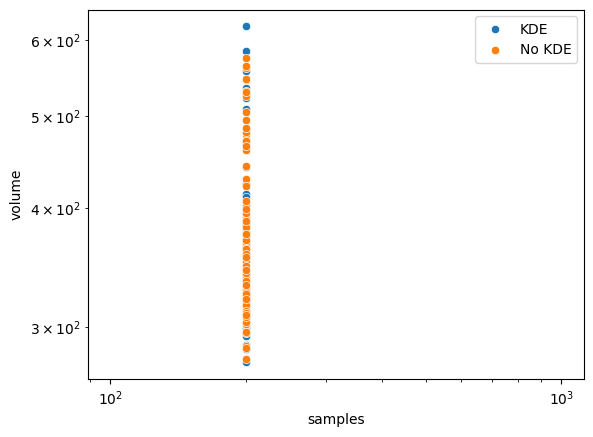

In [19]:
sns.scatterplot(data=kde_data, x='samples', y='volume', label='KDE', )
sns.scatterplot(data=no_kde_data, x='samples', y='volume', label='No KDE',)
plt.xscale('log')
plt.yscale('log')

/usr/local/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/usr/local/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


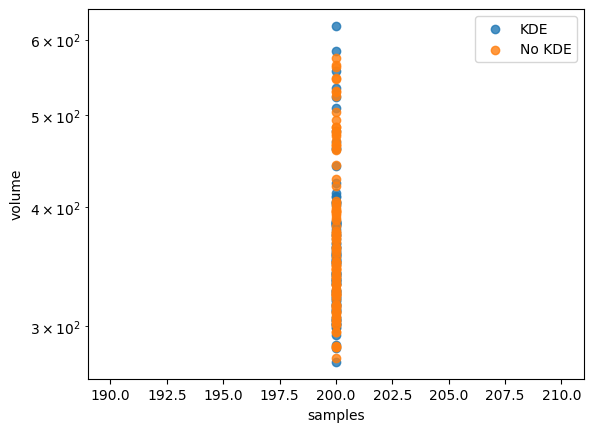

In [20]:

sns.regplot(data=kde_data, x='samples', y='volume', label='KDE', lowess=True)
sns.regplot(data=no_kde_data, x='samples', y='volume', label='No KDE', lowess=True)
# plt.xscale('log')
plt.yscale('log')
plt.legend()

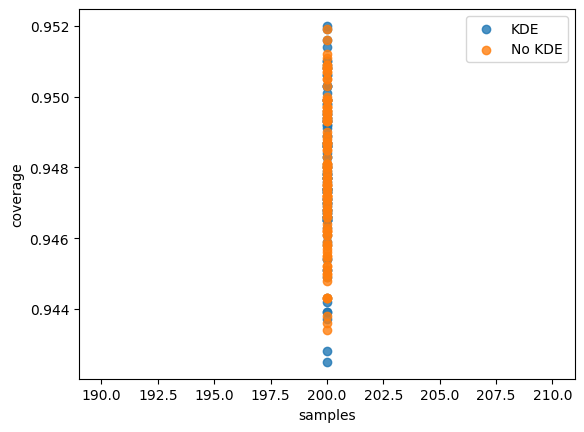

In [21]:
kde_data = data[data['kde'] == True]
no_kde_data = data[data['kde'] == False]
sns.regplot(data=kde_data, x='samples', y='coverage', label='KDE', lowess=True)
sns.regplot(data=no_kde_data, x='samples', y='coverage', label='No KDE', lowess=True)
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

In [22]:
no_kde_data['coverage'].mean() 

0.947822

In [23]:
kde_data['coverage'].mean() 

0.947899

0.9487 337.96755569172103


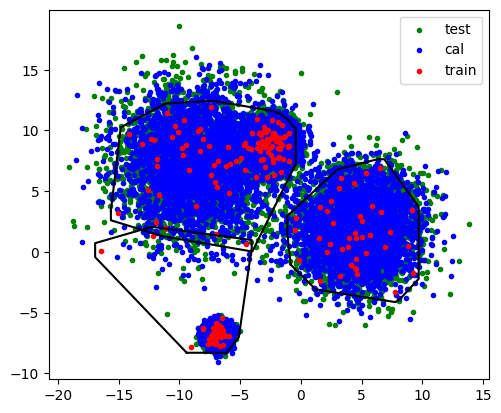

In [26]:
pcr = ConformalRegion(KDE(), MeanShiftClustering(), ConvexHullTemplate, DELTA)
Z_cal_one = Z_train[np.random.choice(Z_train.shape[0], 200, replace=False)]
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
vol = pcr.volume()
scores = pcr.calculate_scores(Z_test) 
coverage = np.sum(scores < 0) / len(scores)
print(coverage, vol)
fig, ax = plt.subplots()
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="cal")
ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="train")

ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)
ax.legend()

In [15]:
silverman = (Z_cal_one.shape[0] * (Z_cal_one.shape[1] + 2) / 4) ** (
                    -1 / (Z_cal_one.shape[1] + 4)
                )
scott = (Z_cal_one.shape[0]) ** (-1 / (Z_cal_one.shape[1] + 4))
print(silverman, scott)

0.41351855420001377 0.41351855420001377


0.9483 318.93194971838943


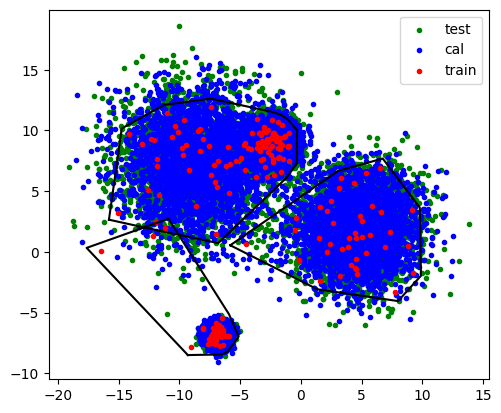

In [27]:
pcr = ConformalRegion(NoOpDensityEstimator(), MeanShiftClustering(), ConvexHullTemplate, DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
vol = pcr.volume()
scores = pcr.calculate_scores(Z_test) 
coverage = np.sum(scores < 0) / len(scores)
print(coverage, vol)
fig, ax = plt.subplots()
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="cal")
ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="train")

ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)
ax.legend()